In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from pyDOE import lhs

Initial points shape: (130000, 3)
Filtered points shape: (123191, 3)


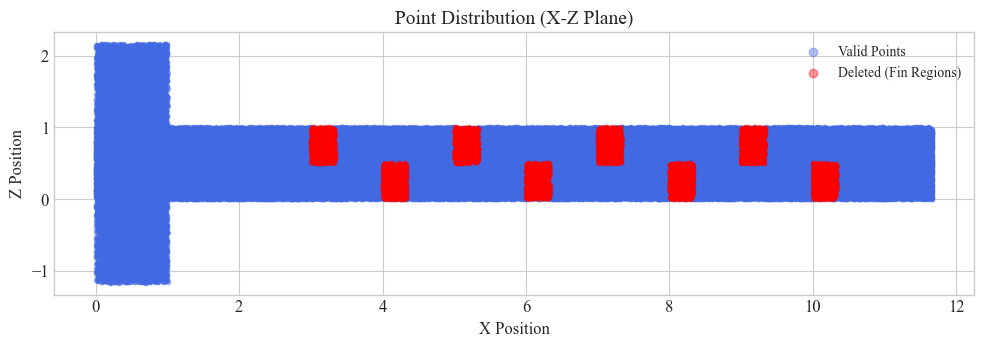

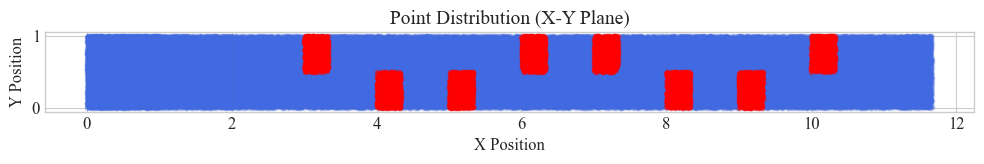

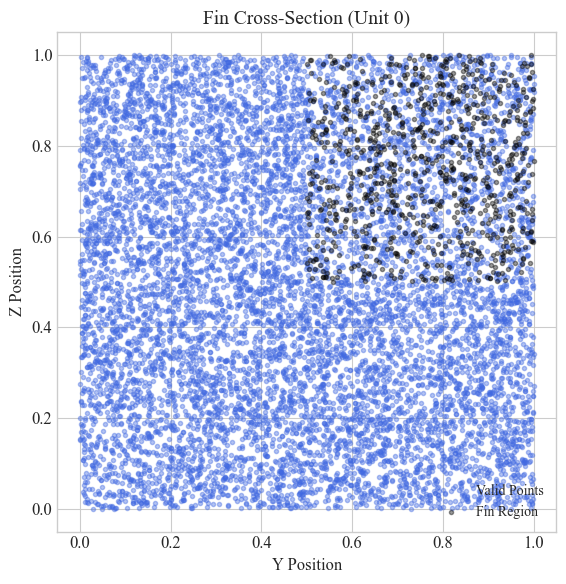

In [32]:
# ==========================
# Geometry Parameters (normalized)
# ==========================
L = 3.5 / 0.3         # Total length (normalized by fin spacing)
L0 = 0.9 / 0.3        # Offset for first fin
d = 0.3 / 0.3         # Depth (normalized)
l = 0.3 / 0.3         # Fin length (normalized)
h = 0.3 / 0.3         # Height (normalized)
L1 = 1 / 0.3          # Reference length
e = (L1 - h) / 2      # Edge offset

nou = 2               # Number of fin units

# Domain bounds
x_min, x_max = 0.0, L
y_min, y_max = 0.0, d
z_min, z_max = 0.0, h

# Fin exclusion ratios (for deleting points inside fins)
p1_max = 1/3          # l/L (length ratio)
p2_max = 1/2          # d/D (depth ratio)
p3_max = 1/2          # h/H (height ratio)

# ==========================
# Sampling Parameters
# ==========================
N_c = 120000          # Collocation points
N_ref = 10000         # Refinement zone points
N_b = 8000            # Boundary points (unused here)
N_i = 2000            # Initial points (unused here)
N_f = 2000            # Final points (unused here)

# ==========================
# Generate Initial Points
# ==========================
ub = np.array([x_max, y_max, z_max])  # Upper bounds
lb = np.array([x_min, y_min, z_min])  # Lower bounds

# Latin Hypercube Sampling (LHS) for main domain and refinement zone
col = [x_min, y_min, z_min] + [x_max - x_min, y_max - y_min, z_max - z_min] * lhs(3, N_c)
colo = [x_min, y_min, -(L1 - h)/2] + [h, d, L1] * lhs(3, N_ref)
col = np.concatenate((col, colo), axis=0)

print(f"Initial points shape: {np.shape(col)}")

# ==========================
# Filter Points Inside Fins
# ==========================
def filter_fin_points(col):
    mask = np.ones(len(col), dtype=bool)
    deleted_points = []
    
    for i in range(len(col)):
        for j in range(nou):
            # Check 4 fin regions per unit (logic for fin exclusion)
            cond1 = (L0 + j * 4*l < col[i, 0] < L0 + j * 4*l + p1_max * l and 
                     d - p2_max * d < col[i, 1] and 
                     col[i, 2] > h - p3_max * h)
            
            cond2 = (L0 + l + j * 4*l < col[i, 0] < L0 + l + j * 4*l + p1_max * l and 
                     p2_max * d > col[i, 1] and 
                     col[i, 2] < p3_max * h)
            
            cond3 = (L0 + 2*l + j * 4*l < col[i, 0] < L0 + 2*l + j * 4*l + p1_max * l and 
                     p2_max * d > col[i, 1] and 
                     col[i, 2] > h - p3_max * h)
            
            cond4 = (L0 + 3*l + j * 4*l < col[i, 0] < L0 + 3*l + j * 4*l + p1_max * l and 
                     d - p2_max * d < col[i, 1] and 
                     col[i, 2] < p3_max * h)
            
            if cond1 or cond2 or cond3 or cond4:
                mask[i] = False
                deleted_points.append(col[i])
    
    col_filtered = col[mask]
    deleted_points = np.array(deleted_points)
    return col_filtered, deleted_points

col, coln = filter_fin_points(col)
print(f"Filtered points shape: {np.shape(col)}")

# ==========================
# Plotting (Improved Styling)
# ==========================
plt.style.use('seaborn-v0_8-whitegrid')  # Clean grid background

# ==============================================
# Enhanced Visualization
# ==============================================
plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams.update({
    'font.family': 'Times New Roman',
    'font.size': 12,
    'axes.titlesize': 14,
    'axes.labelsize': 12
})

# Plot 1: X-Z Plane
fig1, ax1 = plt.subplots(figsize=(10, 5))
ax1.set_aspect('equal')
ax1.scatter(col[:, 0], col[:, 2], marker='.', alpha=0.4, color='royalblue', label='Valid Points')
ax1.scatter(coln[:, 0], coln[:, 2], marker='.', alpha=0.4, color='red', label='Deleted (Fin Regions)')
ax1.set_xlabel('X Position', fontsize=12)
ax1.set_ylabel('Z Position', fontsize=12)
ax1.set_title('Point Distribution (X-Z Plane)', fontsize=14)
ax1.legend(fontsize=10, markerscale=2)
plt.tight_layout()

# Plot 2: X-Y Plane
fig2, ax2 = plt.subplots(figsize=(10, 5))
ax2.set_aspect('equal')
ax2.scatter(col[:, 0], col[:, 1], marker='.', alpha=0.1, color='royalblue', label='Valid Points')
ax2.scatter(coln[:, 0], coln[:, 1], marker='.', alpha=0.4, color='red', label='Deleted (Fin Regions)')
ax2.set_xlabel('X Position', fontsize=12)
ax2.set_ylabel('Y Position', fontsize=12)
ax2.set_title('Point Distribution (X-Y Plane)', fontsize=14)
# ax2.legend(fontsize=10, markerscale=2)
plt.tight_layout()

# Plot 3: Y-Z Plane for Selected Fin (o-th unit)
o = 0  # Fin unit to visualize
fig3, ax3 = plt.subplots(figsize=(6, 6))
ax3.set_aspect('equal')

# Extract points for the selected fin
a = col[(L0 + l*o < col[:, 0]) & (col[:, 0] < L0 + l*(o+1))]
b = coln[(L0 + l*o < coln[:, 0]) & (coln[:, 0] < L0 + l*(o+1))]

ax3.scatter(a[:, 1], a[:, 2], marker='.', alpha=0.4, color='royalblue', label='Valid Points')
ax3.scatter(b[:, 1], b[:, 2], marker='.', alpha=0.4, color='black', label='Fin Region')
ax3.set_xlabel('Y Position', fontsize=12)
ax3.set_ylabel('Z Position', fontsize=12)
ax3.set_title(f'Fin Cross-Section (Unit {o})', fontsize=14)
ax3.legend(fontsize=10)
plt.tight_layout()

plt.show()

C:\Users\HP\AppData\Local\Temp\ipykernel_19440\2464399091.py:104: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax1.legend(fontsize=10)


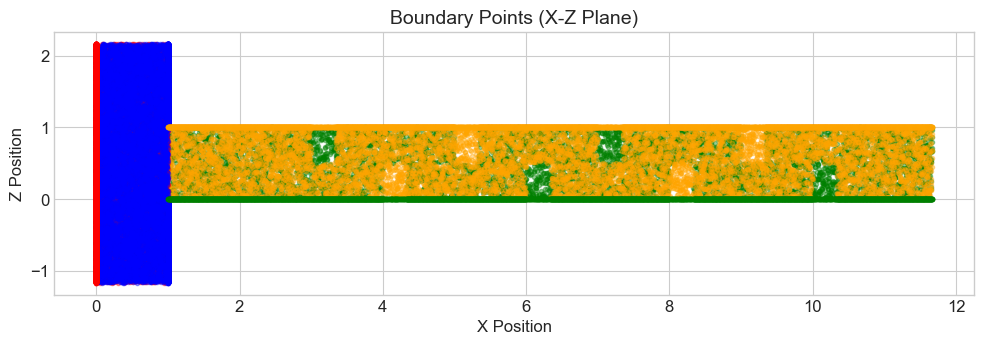

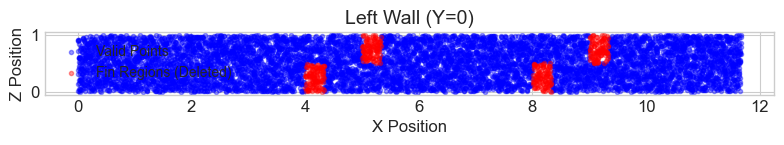

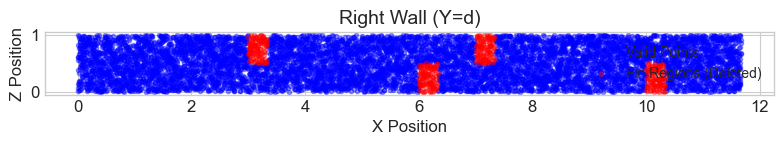

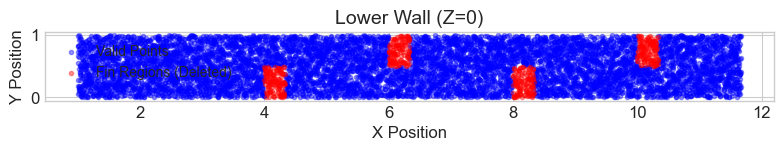

In [31]:
# ==========================
# Boundary Point Generation
# ==========================
# Generate points for each wall using Latin Hypercube Sampling (LHS)
wall_1 = [0.0, 0.0, -(L1-d)/2] + [0.0, d, L1] * lhs(3, N_b)  # Front wall (X=0)
wall_2n = [h, 0.0, -(L1-d)/2] + [0.0, d, L1] * lhs(3, N_b*3)  # Temporary points for back wall (X=h)

# Filter wall_2n to keep only points outside the domain (Z <= 0 or Z >= h)
wall_2 = []
for x in wall_2n:
    if (x[2] <= 0.0 or x[2] >= h):
        wall_2.append([x[0], x[1], x[2]])
    if len(wall_2) >= N_b:
        break
wall_2 = np.array(wall_2)

wall_3 = [0.0, 0.0, -(L1-d)/2] + [h, 0.0, L1] * lhs(3, N_b)  # Bottom wall (Y=0)
wall_4 = [0.0, d, -(L1-d)/2] + [h, 0.0, L1] * lhs(3, N_b)    # Top wall (Y=d)

# Side walls (left/right) and horizontal walls (lower/upper)
wall_5 = [0.0, 0.0, 0.0] + [L, 0.0, h] * lhs(3, N_b)  # Left wall (Y=0)
wall_6 = [0.0, d, 0.0] + [L, 0.0, h] * lhs(3, N_b)    # Right wall (Y=d)
wall_7 = [h, 0.0, 0.0] + [L-h, d, 0.0] * lhs(3, N_b)  # Lower wall (Z=0)
wall_8 = [h, 0.0, h] + [L-h, d, 0.0] * lhs(3, N_b)    # Upper wall (Z=h)

# ==========================
# Filter Points Inside Fins (for walls 5-8)
# ==========================
def filter_wall_points(wall, wall_id):
    """Remove points that lie inside fin regions on specified walls."""
    mask = np.ones(len(wall), dtype=bool)
    deleted_points = []
    
    for i in range(len(wall)):
        for j in range(nou):  # Loop over each fin unit
            # Wall 5 (Left Wall): Delete points in fin cutouts
            if wall_id == 5:
                cond1 = (L0 + l + j*4*l < wall[i, 0] < L0 + l + j*4*l + p1_max*l) and (wall[i, 2] < p3_max*h)
                cond2 = (L0 + 2*l + j*4*l < wall[i, 0] < L0 + 2*l + j*4*l + p1_max*l) and (wall[i, 2] > h - p3_max*h)
                if cond1 or cond2:
                    mask[i] = False
                    deleted_points.append(wall[i])
            
            # Wall 6 (Right Wall): Delete points in fin cutouts
            elif wall_id == 6:
                cond1 = (L0 + j*4*l < wall[i, 0] < L0 + j*4*l + p1_max*l) and (wall[i, 2] > h - p3_max*h)
                cond2 = (L0 + 3*l + j*4*l < wall[i, 0] < L0 + 3*l + j*4*l + p1_max*l) and (wall[i, 2] < p3_max*h)
                if cond1 or cond2:
                    mask[i] = False
                    deleted_points.append(wall[i])
            
            # Wall 7 (Lower Wall): Delete points in fin cutouts
            elif wall_id == 7:
                cond1 = (L0 + l + j*4*l < wall[i, 0] < L0 + l + j*4*l + p1_max*l) and (wall[i, 1] < p2_max*d)
                cond2 = (L0 + 3*l + j*4*l < wall[i, 0] < L0 + 3*l + j*4*l + p1_max*l) and (wall[i, 1] > d - p2_max*d)
                if cond1 or cond2:
                    mask[i] = False
                    deleted_points.append(wall[i])
            
            # Wall 8 (Upper Wall): Delete points in fin cutouts
            elif wall_id == 8:
                cond1 = (L0 + j*4*l < wall[i, 0] < L0 + j*4*l + p1_max*l) and (wall[i, 1] > d - p2_max*d)
                cond2 = (L0 + 2*l + j*4*l < wall[i, 0] < L0 + 2*l + j*4*l + p1_max*l) and (wall[i, 1] < p2_max*d)
                if cond1 or cond2:
                    mask[i] = False
                    deleted_points.append(wall[i])
    
    wall_filtered = wall[mask]
    deleted_points = np.array(deleted_points)
    return wall_filtered, deleted_points

# Apply filtering to walls
wall_5, walld5 = filter_wall_points(wall_5, 5)
wall_6, walld6 = filter_wall_points(wall_6, 6)
wall_7, walld7 = filter_wall_points(wall_7, 7)
wall_8, walld8 = filter_wall_points(wall_8, 8)

# ==========================
# Inlet/Outlet Points
# ==========================
inlet_1 = [x_min, y_min, z_min] + [h, d, 0.0] * lhs(3, N_i)  # Inlet (Z=0)
inlet_2 = [x_min, y_min, z_max] + [h, d, 0.0] * lhs(3, N_i)  # Secondary inlet (unused?)
outlet = [L, 0.0, 0.0] + [0.0, d, h] * lhs(3, N_i)           # Outlet (X=L)

# ==========================
# Plotting (Improved Styling)
# ==========================
plt.style.use('seaborn-v0_8-whitegrid')

# Plot 1: Front/Back/Lower/Upper Walls
fig1, ax1 = plt.subplots(figsize=(10, 6))
ax1.set_aspect('equal')
ax1.scatter(wall_5[:, 0], wall_5[:, 2], marker='.', alpha=0.4, color='green')
ax1.scatter(wall_6[:, 0], wall_6[:, 2], marker='.', alpha=0.4, color='orange')
ax1.scatter(wall_3[:, 0], wall_3[:, 2], marker='.', alpha=0.4, color='red')
ax1.scatter(wall_4[:, 0], wall_4[:, 2], marker='.', alpha=0.4, color='blue')
ax1.scatter(wall_1[:, 0], wall_1[:, 2], marker='.', alpha=0.4, color='red')
ax1.scatter(wall_2[:, 0], wall_2[:, 2], marker='.', alpha=0.4, color='blue')
ax1.scatter(wall_7[:, 0], wall_7[:, 2], marker='.', alpha=0.4, color='green')
ax1.scatter(wall_8[:, 0], wall_8[:, 2], marker='.', alpha=0.4, color='orange')
ax1.set_xlabel('X Position', fontsize=12)
ax1.set_ylabel('Z Position', fontsize=12)
ax1.set_title('Boundary Points (X-Z Plane)', fontsize=14)
ax1.legend(fontsize=10)
plt.tight_layout()

# Plot 2: Left Wall (Wall 5)
fig2, ax2 = plt.subplots(figsize=(8, 5))
ax2.set_aspect('equal')
ax2.scatter(wall_5[:, 0], wall_5[:, 2], marker='.', alpha=0.4, color='blue', label='Valid Points')
ax2.scatter(walld5[:, 0], walld5[:, 2], marker='.', alpha=0.4, color='red', label='Fin Regions (Deleted)')
ax2.set_xlabel('X Position', fontsize=12)
ax2.set_ylabel('Z Position', fontsize=12)
ax2.set_title('Left Wall (Y=0)', fontsize=14)
ax2.legend(fontsize=10)
plt.tight_layout()

# Plot 3: Right Wall (Wall 6)
fig3, ax3 = plt.subplots(figsize=(8, 5))
ax3.set_aspect('equal')
ax3.scatter(wall_6[:, 0], wall_6[:, 2], marker='.', alpha=0.4, color='blue', label='Valid Points')
ax3.scatter(walld6[:, 0], walld6[:, 2], marker='.', alpha=0.4, color='red', label='Fin Regions (Deleted)')
ax3.set_xlabel('X Position', fontsize=12)
ax3.set_ylabel('Z Position', fontsize=12)
ax3.set_title('Right Wall (Y=d)', fontsize=14)
ax3.legend(fontsize=10)
plt.tight_layout()

# Plot 4: Lower Wall (Wall 7)
fig4, ax4 = plt.subplots(figsize=(8, 5))
ax4.set_aspect('equal')
ax4.scatter(wall_7[:, 0], wall_7[:, 1], marker='.', alpha=0.4, color='blue', label='Valid Points')
ax4.scatter(walld7[:, 0], walld7[:, 1], marker='.', alpha=0.4, color='red', label='Fin Regions (Deleted)')
ax4.set_xlabel('X Position', fontsize=12)
ax4.set_ylabel('Y Position', fontsize=12)
ax4.set_title('Lower Wall (Z=0)', fontsize=14)
ax4.legend(fontsize=10)
plt.tight_layout()

plt.show()

Fin points shape: (16000, 3)


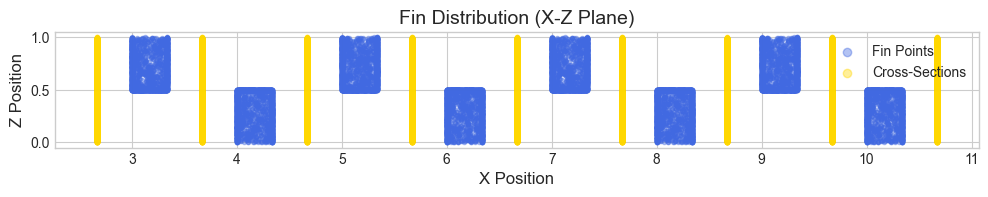

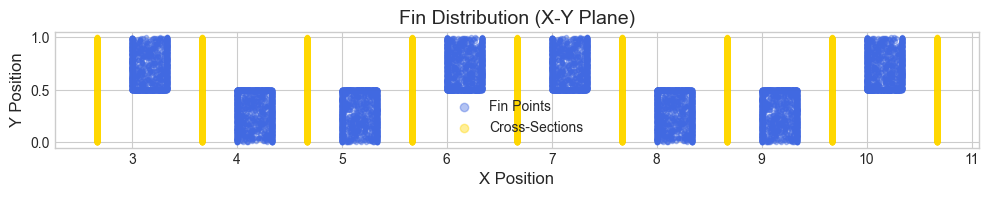

In [21]:
# ==========================
# Fin Point Generation
# ==========================
# Generate base points for each fin type using LHS
fin0 = [L0, d, h] + [p1_max * l, -p2_max * d, -p3_max * h] * lhs(3, N_f)  # Top-right fin
fin1 = [L0 + l, 0.0, 0.0] + [p1_max * l, p2_max * d, p3_max * h] * lhs(3, N_f)  # Bottom-left fin
fin2 = [L0 + 2*l, 0.0, h] + [p1_max * l, p2_max * d, -p3_max * h] * lhs(3, N_f)  # Top-left fin
fin3 = [L0 + 3*l, d, 0.0] + [p1_max * l, -p2_max * d, p3_max * h] * lhs(3, N_f)  # Bottom-right fin

# Initialize lists for Jacobian points (used for sensitivity analysis)
fin_Jx, fin_Jy, fin_Jz = [], [], []

# Randomly assign points to different Jacobian components (X/Y/Z)
for i in range(len(fin1)):
    random_choice = np.random.choice(4, 1)[0]
    
    # Case 0: Points aligned with fin start (X-direction)
    if random_choice == 0:
        fin0[i, 0] = L0
        fin1[i, 0] = L0 + l
        fin2[i, 0] = L0 + 2*l
        fin3[i, 0] = L0 + 3*l
        for j in range(nou):
            offset = np.array([j * 4 * l, 0, 0])
            fin_Jx.extend([fin0[i, :] + offset, fin1[i, :] + offset, 
                          fin2[i, :] + offset, fin3[i, :] + offset])
    
    # Case 1: Points aligned with fin end (X-direction)
    elif random_choice == 1:
        fin0[i, 0] = L0 + p1_max * l
        fin1[i, 0] = L0 + l + p1_max * l
        fin2[i, 0] = L0 + 2*l + p1_max * l
        fin3[i, 0] = L0 + 3*l + p1_max * l
        for j in range(nou):
            offset = np.array([j * 4 * l, 0, 0])
            fin_Jx.extend([fin0[i, :] + offset, fin1[i, :] + offset, 
                          fin2[i, :] + offset, fin3[i, :] + offset])
    
    # Case 2: Points aligned with Y-boundaries
    elif random_choice == 2:
        fin0[i, 1] = d - p2_max * d
        fin1[i, 1] = p2_max * d
        fin2[i, 1] = p2_max * d
        fin3[i, 1] = d - p2_max * d
        for j in range(nou):
            offset = np.array([j * 4 * l, 0, 0])
            fin_Jy.extend([fin0[i, :] + offset, fin1[i, :] + offset, 
                          fin2[i, :] + offset, fin3[i, :] + offset])
    
    # Case 3: Points aligned with Z-boundaries
    elif random_choice == 3:
        fin0[i, 2] = h - p3_max * h
        fin1[i, 2] = p3_max * h
        fin2[i, 2] = h - p3_max * h
        fin3[i, 2] = p3_max * h
        for j in range(nou):
            offset = np.array([j * 4 * l, 0, 0])
            fin_Jz.extend([fin0[i, :] + offset, fin1[i, :] + offset, 
                          fin2[i, :] + offset, fin3[i, :] + offset])

# Combine all fin points (including all units)
fins = np.ones((N_f * nou * 4, 3))
for i in range(nou):
    offset = np.array([i * 4 * l, 0, 0])
    fins[i*4*N_f:(i*4+1)*N_f, :] = fin0 + offset
    fins[(i*4+1)*N_f:(i*4+2)*N_f, :] = fin1 + offset
    fins[(i*4+2)*N_f:(i*4+3)*N_f, :] = fin2 + offset
    fins[(i*4+3)*N_f:(i*4+4)*N_f, :] = fin3 + offset

# Convert Jacobian lists to arrays
fin_Jx = np.array(fin_Jx)
fin_Jy = np.array(fin_Jy)
fin_Jz = np.array(fin_Jz)

# ==========================
# Cross-Section Points (for visualization)
# ==========================
fsloc = (L0 + L0 + l + p1_max * l) / 2  # Midpoint of first fin
n = nou * 4
secs = []
for i in range(-1, n):
    sec = [fsloc + l * i, 0.0, 0.0] + [0.0, d, h] * lhs(3, N_i)
    secs.append(sec)
secs = np.array(secs)

print(f"Fin points shape: {np.shape(fins)}")

# ==========================
# Plotting (Enhanced Visuals)
# ==========================
plt.style.use('seaborn-v0_8-whitegrid')

# Plot 1: X-Z Plane (Fins vs Cross-Sections)
fig1, ax1 = plt.subplots(figsize=(10, 5))
ax1.set_aspect('equal')
ax1.scatter(fins[:, 0], fins[:, 2], marker='.', alpha=0.4, color='royalblue', label='Fin Points')
ax1.scatter(secs[:, :, 0].flatten(), secs[:, :, 2].flatten(), 
            marker='.', alpha=0.4, color='gold', label='Cross-Sections')
ax1.set_xlabel('X Position', fontsize=12)
ax1.set_ylabel('Z Position', fontsize=12)
ax1.set_title('Fin Distribution (X-Z Plane)', fontsize=14)
ax1.legend(fontsize=10, markerscale=2)
plt.tight_layout()

# Plot 2: X-Y Plane (Fins vs Cross-Sections)
fig2, ax2 = plt.subplots(figsize=(10, 5))
ax2.set_aspect('equal')
ax2.scatter(fins[:, 0], fins[:, 1], marker='.', alpha=0.4, color='royalblue', label='Fin Points')
ax2.scatter(secs[:, :, 0].flatten(), secs[:, :, 1].flatten(), 
            marker='.', alpha=0.4, color='gold', label='Cross-Sections')
ax2.set_xlabel('X Position', fontsize=12)
ax2.set_ylabel('Y Position', fontsize=12)
ax2.set_title('Fin Distribution (X-Y Plane)', fontsize=14)
ax2.legend(fontsize=10, markerscale=2)
plt.tight_layout()

plt.show()

In [ ]:
# ====================================================================
# Boundary Condition Setup
# ====================================================================

# Combine all wall and fin points into a single array
walls = np.concatenate((wall_1, wall_2, wall_3, wall_4, 
                        wall_5, wall_6, wall_7, wall_8, fins), axis=0)

# Initialize zero velocity for all wall points (no-slip condition)
wall_uvw = np.zeros_like(walls[:, :3])  # [u=0, v=0, w=0] for all walls

# ====================================================================
# Inlet Velocity Profile (Parabolic)
# ====================================================================

# Calculate parabolic inlet profile (w-component only)
# Profile shape: w(y,x) = (16/h⁴)(y(h-y))(x(h-x))
w1 = (16/(h**4)) * (inlet_1[:,1] * h - np.square(inlet_1[:,1])) * \
                  (inlet_1[:,0] * h - np.square(inlet_1[:,0]))
w1 = w1.reshape(-1, 1)  # Reshape to column vector

# Second inlet has opposite flow direction
w2 = -w1.copy()  # Negative of first inlet profile

# Assemble inlet velocity vectors [u=0, v=0, w=parabolic]
inlet_uvw1 = np.hstack([np.zeros_like(inlet_1[:,0:1]),  # u=0
                        np.zeros_like(inlet_1[:,1:2]),  # v=0
                        w1])                           # w=parabolic

inlet_uvw2 = np.hstack([np.zeros_like(inlet_2[:,0:1]),  # u=0
                        np.zeros_like(inlet_2[:,1:2]),  # v=0
                        w2])                           # w=parabolic

# Combine inlet/outlet points (for visualization)
inout = np.stack((inlet_1, inlet_2, outlet), axis=2)

# ====================================================================
# Jacobian Points for Sensitivity Analysis
# ====================================================================

# Group points by directional sensitivity:
wall_Jx = np.concatenate((wall_1, wall_2, fin_Jx), axis=0)  # X-sensitive
wall_Jy = np.concatenate((wall_3, wall_4, wall_5, wall_6, fin_Jy), axis=0)  # Y-sensitive
wall_Jz = np.concatenate((wall_7, wall_8, fin_Jz), axis=0)  # Z-sensitive

# ====================================================================
# Final Boundary Condition Assembly
# ====================================================================

# Combine all boundary points and their velocities
bc_points = np.concatenate([inlet_1, inlet_2, walls], axis=0)
bc_velocities = np.concatenate([inlet_uvw1, inlet_uvw2, wall_uvw], axis=0)

# ====================================================================
# Diagnostic Output
# ====================================================================
print('\n=== Point Count Summary ===')
print(f'Collocation points: {col.shape}')
print(f'Wall points: {walls.shape}')
print(f'Inlet/Outlet points: {inout.shape}')
print(f'Boundary condition points: {bc_points.shape}')
print(f'Boundary velocities: {bc_velocities.shape}')
print(f'Cross-section points: {secs.shape}\n')



=== Point Count Summary ===
Collocation points: (123210, 3)
Wall points: (78055, 3)
Inlet/Outlet points: (2000, 3, 3)
Boundary condition points: (82055, 3)
Boundary velocities: (82055, 3)
Cross-section points: (9, 2000, 3)



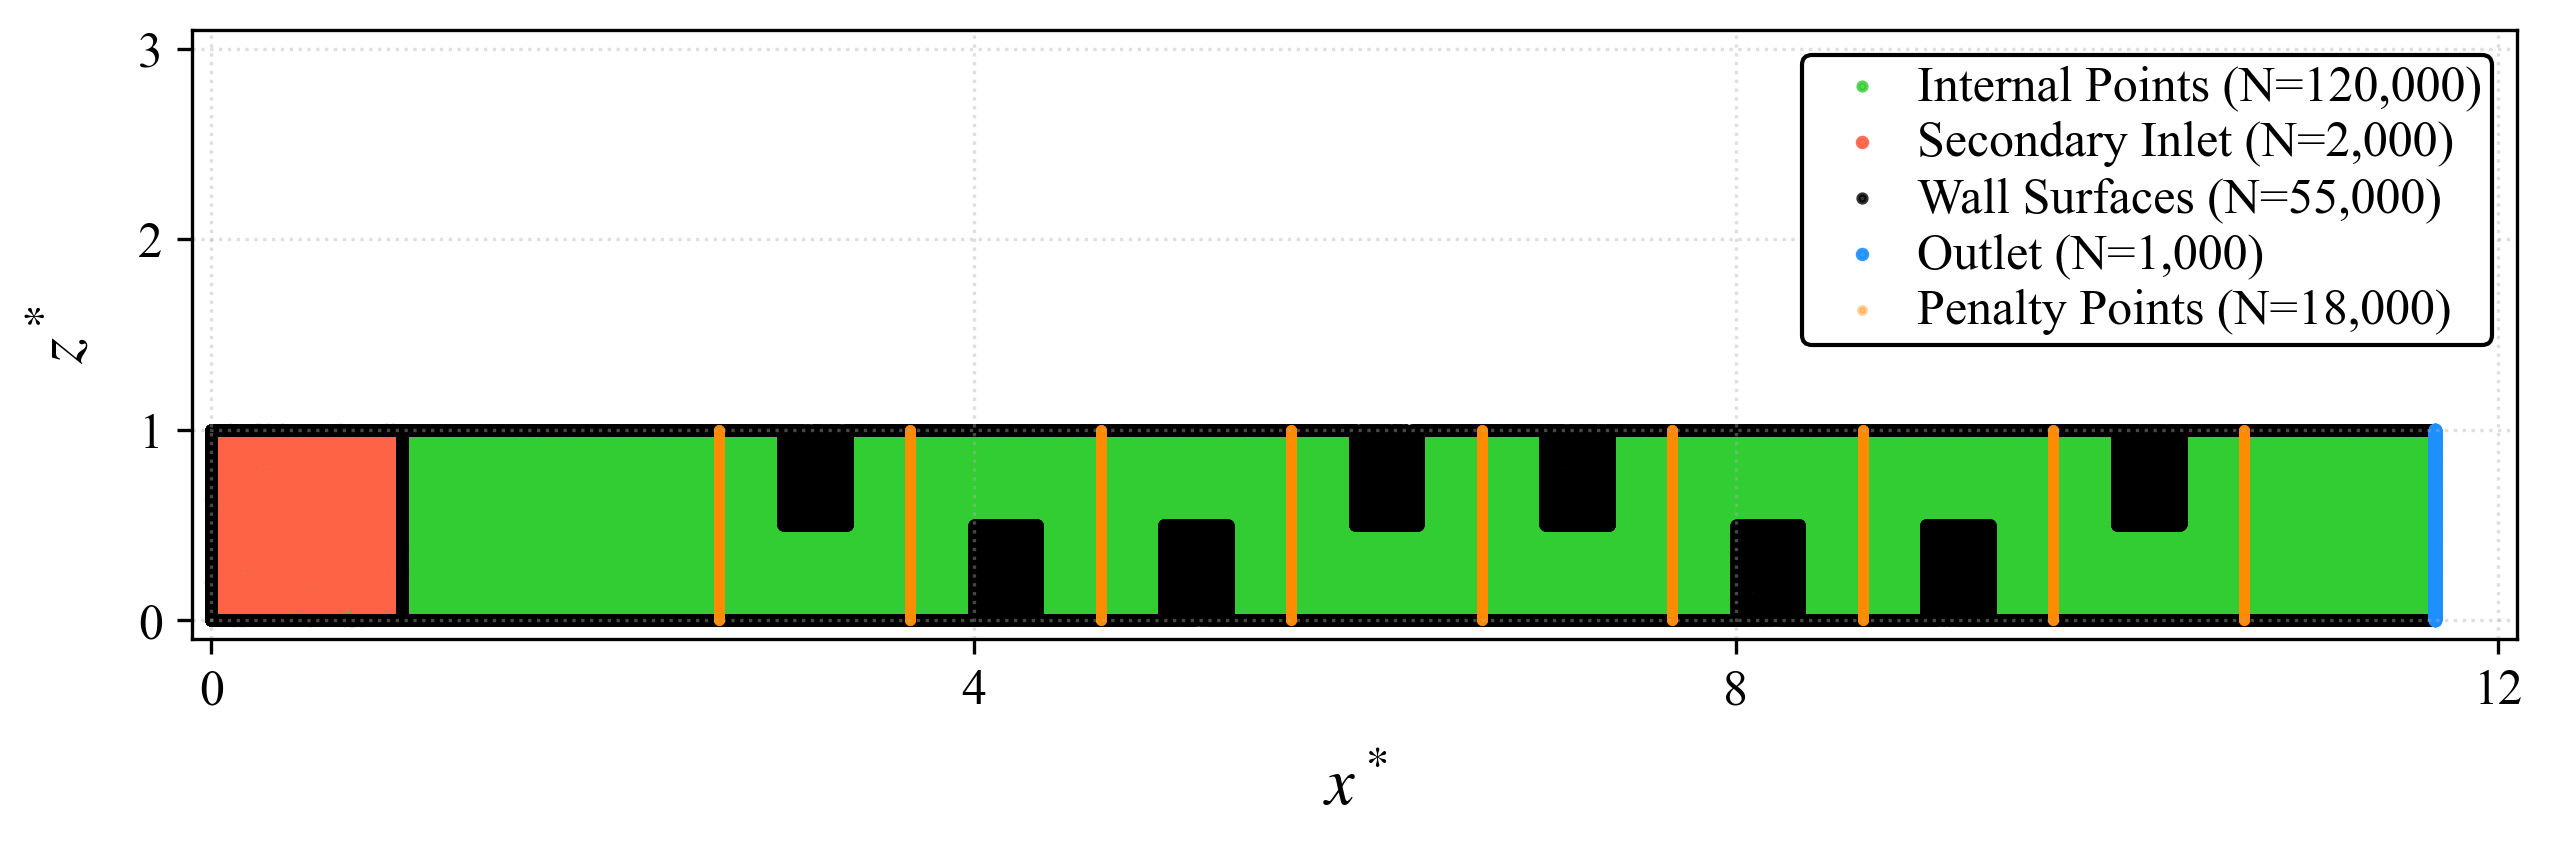

In [28]:
import matplotlib.pyplot as plt
import numpy as np

# ==============================================
# Plot Configuration
# ==============================================
plt.style.use('default')
plt.rcParams.update({
    'font.family': 'Times New Roman',
    'font.size': 12,
    'mathtext.fontset': 'stix',
    'axes.titlesize': 14,
    'axes.labelsize': 12
})

fig, ax = plt.subplots(figsize=(10, 6), dpi=300)
ax.set_aspect('equal')

# ==============================================
# Data Preparation
# ==============================================
# Filter boundary points in middle Z-range (10%-90% height)
mid_z_points = bc[(h*0.1 < bc[:,2]) & (bc[:,2] < h*0.9)]

# ==============================================
# Scatter Plots with Enhanced Styling
# ==============================================
# Internal points
ax.scatter(col[:,0], col[:,1], 
           marker='.', s=15, alpha=0.8, color='limegreen',
           label='Internal Points (N=120,000)')

# Inlet/Outlet points
# ax.scatter(inlet_1[:,0], inlet_1[:,1],
#            marker='.', s=20, alpha=0.9, color='gold',
#            label='Primary Inlet (N=2,000)')

ax.scatter(inlet_2[:,0], inlet_2[:,1],
           marker='.', s=20, alpha=0.9, color='tomato',
           label='Secondary Inlet (N=2,000)')

# Boundary points
ax.scatter(mid_z_points[:,0], mid_z_points[:,1],
           marker='.', s=15, alpha=0.8, color='black',
           label='Wall Surfaces (N=55,000)')

ax.scatter(wall_2[:,0], wall_2[:,1],
           marker='.', s=15, alpha=0.8, color='black')

ax.scatter(outlet[:,0], outlet[:,1],
           marker='.', s=20, alpha=0.9, color='dodgerblue',
           label='Outlet (N=1,000)')

# Penalty points
ax.scatter(secs[:,:,0].flatten(), secs[:,:,1].flatten(),
           marker='.', s=10, alpha=0.4, color='darkorange',
           label='Penalty Points (N=18,000)')

# ==============================================
# Axis Labels and Formatting
# ==============================================
ax.set_xlabel(r'$x^*$', fontsize=16, labelpad=10)
ax.set_ylabel(r'$z^*$', fontsize=16, labelpad=10)

ax.set_xticks([0.0, 4.0, 8.0, 12.0])
ax.set_yticks([0.0, 1.0, 2.0, 3.0])

ax.set_xlim(-0.1, 12.1)
ax.set_ylim(-0.1, 3.1)

# ==============================================
# Legend and Grid
# ==============================================
legend = ax.legend(loc='best', framealpha=1, 
                  handletextpad=0.1, 
                  borderpad=0.2,
                  labelspacing=0.2)
legend.get_frame().set_edgecolor('black')

ax.grid(True, linestyle=':', alpha=0.4)

# ==============================================
# Save Figure
# ==============================================
# plt.tight_layout()
# plt.savefig("domain_points.png", dpi=900, bbox_inches='tight')
# plt.show()